# MRI Classification Using PyTorch
This notebook demonstrates how to load an MRI dataset, split it into training and validation sets, define a custom CNN model, and train the model using PyTorch.

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

## Data Preparation
Load the dataset and split it into training and validation sets. We will apply data augmentations to the training set.

In [2]:
# Define transformations for training and validation sets
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets from directories
train_dataset = ImageFolder(root='dataset_train', transform=transform_train)
val_dataset = ImageFolder(root='dataset_val', transform=transform_val)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

## Transfer Learning

Pre-trained models are typically trained on large datasets, such as ImageNet, which contains millions of images and thousands of classes. Transfer learning leverages this prior knowledge to benefit a new, often smaller dataset.

In [3]:
import torchvision.models as models

# Number of classes in your dataset
num_classes = 4  # glioma, meningioma, notumor, pituitary

# Load a pre-trained ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)  # num_classes is the number of classes in your dataset

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Optionally, freeze all layers except the final layer if needed
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True

In [4]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training and evaluation
num_epochs = 25  # Increase the number of epochs
best_val_loss = float('inf')
early_stopping_patience = 5  # Number of epochs with no improvement after which training will be stopped
epochs_no_improve = 0  # Track epochs with no improvement
best_epoch = 0  # Track the best epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    print(f'Train - Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    
    print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
    
    # Save the model if validation loss has decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1  # Update best epoch
        epochs_no_improve = 0  # Reset the counter
        filename = f'models/transfer_resnet_best.pth'
        torch.save(model.state_dict(), filename)
        print(f'Best model saved as {filename}')
    else:
        epochs_no_improve += 1
    
    # Early stopping
    if epochs_no_improve >= early_stopping_patience:
        print('Early stopping!')
        break

print('Training complete')

Train - Epoch 1/25, Loss: 1.3013, Accuracy: 0.3862
Validation - Epoch 1/25, Loss: 1.0371, Accuracy: 0.6763
Best model saved as transfer_resnet_best.pth
Train - Epoch 2/25, Loss: 0.9224, Accuracy: 0.6555
Validation - Epoch 2/25, Loss: 0.8354, Accuracy: 0.7338
Best model saved as transfer_resnet_best.pth
Train - Epoch 3/25, Loss: 0.8001, Accuracy: 0.7203
Validation - Epoch 3/25, Loss: 0.7720, Accuracy: 0.7302
Best model saved as transfer_resnet_best.pth
Train - Epoch 4/25, Loss: 0.6580, Accuracy: 0.7871
Validation - Epoch 4/25, Loss: 0.6545, Accuracy: 0.8129
Best model saved as transfer_resnet_best.pth
Train - Epoch 5/25, Loss: 0.5887, Accuracy: 0.8079
Validation - Epoch 5/25, Loss: 0.5393, Accuracy: 0.8705
Best model saved as transfer_resnet_best.pth
Train - Epoch 6/25, Loss: 0.5682, Accuracy: 0.8372
Validation - Epoch 6/25, Loss: 0.5241, Accuracy: 0.8273
Best model saved as transfer_resnet_best.pth
Train - Epoch 7/25, Loss: 0.5617, Accuracy: 0.7912
Validation - Epoch 7/25, Loss: 0.5717

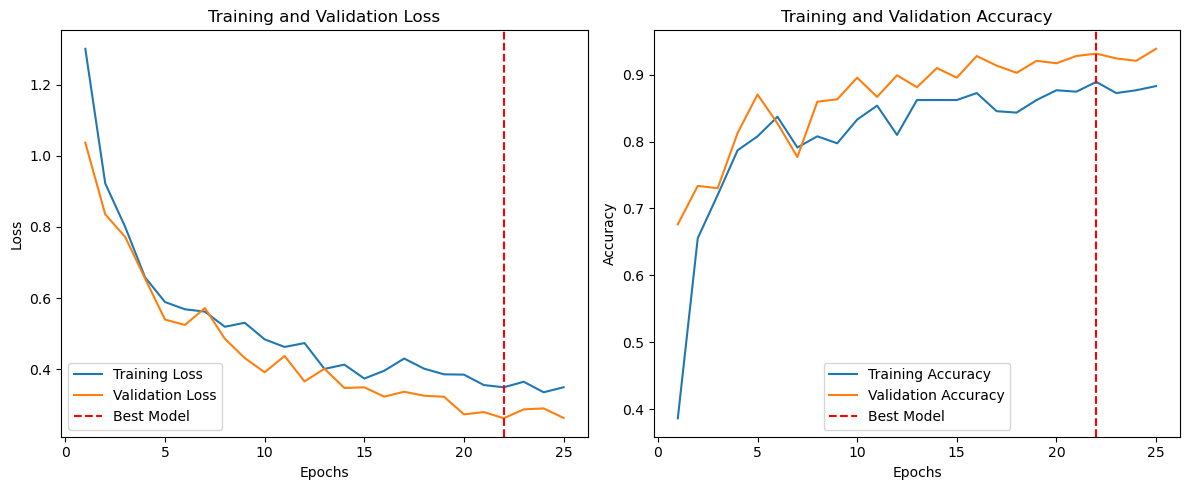

In [5]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test

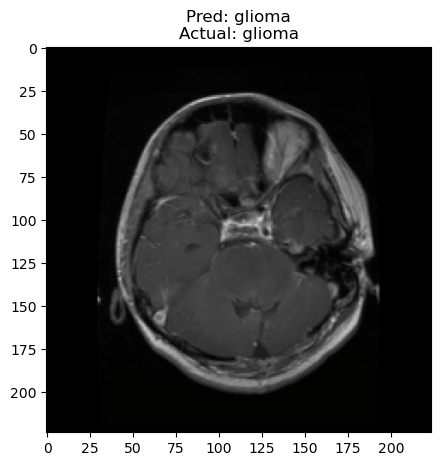

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Ensure Matplotlib inline backend is set
%matplotlib inline

# Get one batch of validation data
inputs, classes = next(iter(val_loader))

inputs = inputs.to(device)
classes = classes.to(device)
# Load the entire model

#Instantiate the model architecture
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer with the number of classes in your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Load the model state dictionary
model.load_state_dict(torch.load('models/transfer_resnet_best.pth'))

model = model.to(device)
# Move the model to the appropriate device
# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

# Move the inputs and classes to CPU for visualization
inputs = inputs.cpu()
classes = classes.cpu()
preds = preds.cpu()

# Class names
class_names = train_dataset.classes

# Randomly choose one data point to visualize
index = random.randint(0, len(inputs) - 1)  # Select a random index from the batch
input_image = inputs[index]
predicted_label = class_names[preds[index]]
actual_label = class_names[classes[index]]

# Plot the image along with its predicted and actual labels
plt.figure(figsize=(5, 5))
imshow(input_image, title=f"Pred: {predicted_label}\nActual: {actual_label}")
plt.show()
